# TIME SERIES FORECASTING

In [148]:
!pip install pmdarima

In [18]:
# importing the necessary libraries
import os # working directory
import warnings # Ensure ignore /no warnings are displayed 
import itertools
import numpy as np # Data Processing
import matplotlib.pyplot as plt # Visualization
import pandas as pd # Data Processing 
import statsmodels.api as sm # Forecasting
import matplotlib
from pylab import rcParams # Setting up the chart elements/visualization
from statsmodels.tsa.stattools import adfuller # Stationarity
from numpy import log # Stationarity
from pmdarima.arima.utils import ndiffs # Stationarity/Differncing 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF and PACF Plots
from statsmodels.tsa.arima_model import ARIMA # Applying ARIMA
import pmdarima as pm # Applying ARIMA


In [3]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## FORECASTING OFFICE SUPPLIES SALES FOR THE RETAIL STORE

### Reading The Data ForFurther Analysis 

In [4]:
os.chdir(R'C:\Users\TANIA DAS\Downloads') # Setting the working directory
#loading the xls data into a data frame
df = pd.read_excel("Superstore_Office_Supplies.xls")
print("Data is imported successfully")
Office_Supplies = df.loc[df['Category'] == 'Office Supplies']# Filtering out the data only for office supplies since i will be forecasting office supplies sales

Data is imported successfully


In [5]:
print(Office_Supplies['Order Date'].min())
print(Office_Supplies['Order Date'].max())

2014-01-03 00:00:00
2017-12-30 00:00:00


We have 4 years of data for office supplies in our dataset

### Data Preprocessing

In [6]:
#Checking Missing Values
Office_Supplies.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

There are no missinng values in the dataset

In [7]:
#Arranging the Data chronoligcally
Office_Supplies =Office_Supplies.groupby('Order Date')['Sales'].sum().reset_index()


In [8]:
#Indexing with Time Series
Office_Supplies = Office_Supplies.set_index('Order Date')
Office_Supplies.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06',
               '2014-01-07', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-16', '2014-01-18',
               ...
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1148, freq=None)

In [9]:
#Work at the Average Monthly Sales
y = Office_Supplies['Sales'].resample('MS').mean()


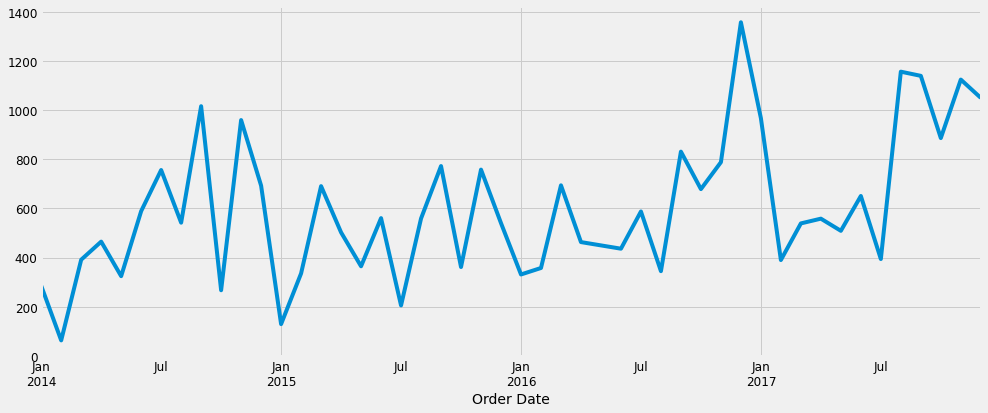

In [10]:
y.plot(figsize=(15, 6))
plt.show()

### Decomposing the Data: Trend, Seasonal and Irregular Component 

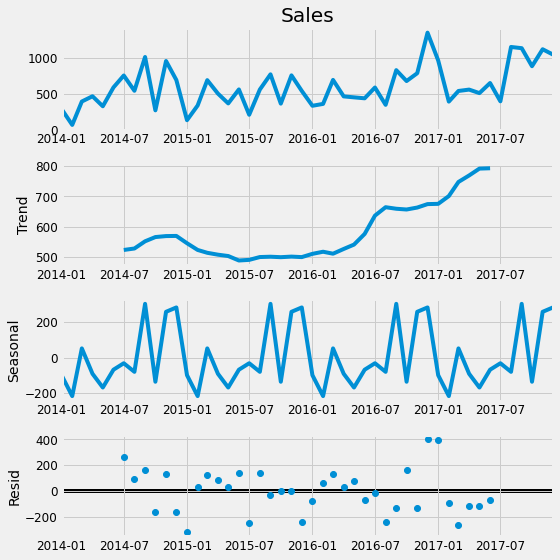

In [11]:
rcParams['figure.figsize'] = 8, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()


### Checking the Stationarity of the Model

In [12]:
y_1 = y.reset_index()

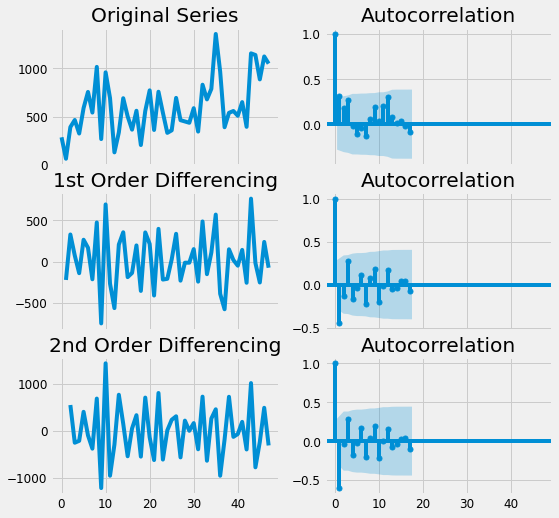

In [13]:
#Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(y_1.Sales); axes[0, 0].set_title('Original Series')
plot_acf(y_1.Sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_1.Sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_1.Sales.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_1.Sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_1.Sales.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

#### ADF Test

In [14]:
result_1 = adfuller(y_1.Sales.diff().dropna())
print('ADF Statistic: %f' % result_1[0])
print('p-value: %f' % result_1[1])


ADF Statistic: -8.603123
p-value: 0.000000


Since the p-value<=0.05,we can say that  the data has achieved stationary at first order differencing only

### Finding the AR Term of Model

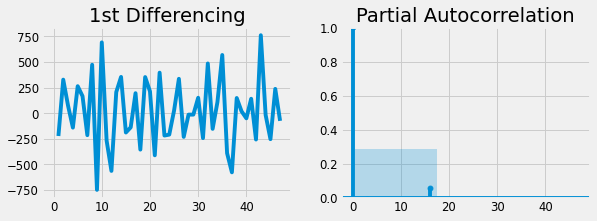

In [15]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':70})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_1.Sales.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1))
plot_pacf(y_1.Sales.diff().dropna(), ax=axes[1])

plt.show()

### Finding the MA Term of Model

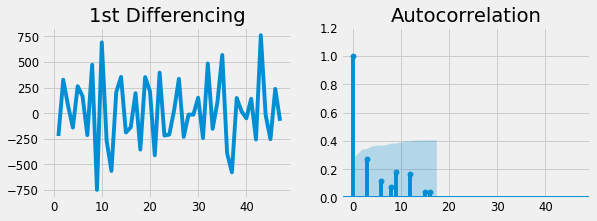

In [16]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_1.Sales.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_1.Sales.diff().dropna(), ax=axes[1])

plt.show()

### Time Series Forecasting  with SARIMA 

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

Trend Elements There are three trend elements that require configuration.
p: Trend autoregression order. d: Trend difference order. q: Trend moving average order.

Seasonal Elements There are four seasonal elements:
P: Seasonal autoregressive order. D: Seasonal difference order. Q: Seasonal moving average order. m: The number of time steps for a single seasonal period.

The notation for a SARIMA model is specified as: SARIMA(p,d,q)(P,D,Q,m)


In [28]:
p=q=range(0,3)
d=range(1,2)
for i in itertools.product(p,d,q):
    print(i)

(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)


In [29]:
pdq=list(itertools.product(p,d,q))

In [30]:
seasonal_pdq=[(x[0],x[1],x[2],12)for x in list(itertools.product(p,d,q))]
print('Examples of parameter combinations for Seasonal ARIMA:')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA:
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)


In [31]:
for param in pdq: #for loop for determining the best combination of seasonal parameters for SARIMA
    for param_seasonal in seasonal_pdq:
        
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,# Not Enforcing Stationarity,
                                            enforce_invertibility=False)#Models do converge, Model is estimatble 
            results = mod.fit()
            pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
            pred_ci = pred.conf_int()
            y_forecasted = pred.predicted_mean
            y_truth = y['2017-01-01':]
            mape = np.mean(np.abs(y_forecasted - y_truth)/np.abs(y_truth))
            print('SARIMAX{}x{} - mape:{}'.format(param, param_seasonal,mape))
            

SARIMAX(0, 1, 0)x(0, 1, 0, 12) - mape:0.5023493154704108
SARIMAX(0, 1, 0)x(0, 1, 1, 12) - mape:0.35754349619465825
SARIMAX(0, 1, 0)x(0, 1, 2, 12) - mape:0.3380546826619717
SARIMAX(0, 1, 0)x(1, 1, 0, 12) - mape:0.3286692157555934
SARIMAX(0, 1, 0)x(1, 1, 1, 12) - mape:0.3389582882777112
SARIMAX(0, 1, 0)x(1, 1, 2, 12) - mape:0.40148198289969733
SARIMAX(0, 1, 0)x(2, 1, 0, 12) - mape:0.3538307524613274
SARIMAX(0, 1, 0)x(2, 1, 1, 12) - mape:0.3537625457883906
SARIMAX(0, 1, 0)x(2, 1, 2, 12) - mape:0.40497385795186047
SARIMAX(0, 1, 1)x(0, 1, 0, 12) - mape:0.33720268786876223
SARIMAX(0, 1, 1)x(0, 1, 1, 12) - mape:0.27338732776748614
SARIMAX(0, 1, 1)x(0, 1, 2, 12) - mape:0.26981254975947505
SARIMAX(0, 1, 1)x(1, 1, 0, 12) - mape:0.2748679908665953
SARIMAX(0, 1, 1)x(1, 1, 1, 12) - mape:0.28684343191121864
SARIMAX(0, 1, 1)x(1, 1, 2, 12) - mape:0.33252296790054947
SARIMAX(0, 1, 1)x(2, 1, 0, 12) - mape:0.2537545531984278
SARIMAX(0, 1, 1)x(2, 1, 1, 12) - mape:0.2636944040580534
SARIMAX(0, 1, 1)x(2, 1,

The above output suggests that SARIMAX(2,1,1)x(2,1,2,12) yields the lowest mean absolute percentage error (MAPE)  of 0.19962620074089552 .Therefore we should consider this  to be  the optimal option. 

### Fitting The SARIMA Model

In [39]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2,1,1),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,# Not Enforcing Stationarity, 
                                enforce_invertibility=False)#Models do converge, Model is estimatble
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0489      0.804      0.061      0.951      -1.526       1.624
ar.L2         -0.3049      0.550     -0.555      0.579      -1.382       0.772
ma.L1          0.5536      1.523      0.364      0.716      -2.431       3.538
ar.S.L12      -1.2831      1.346     -0.953      0.340      -3.921       1.354
ar.S.L24       0.0061      2.340      0.003      0.998      -4.580       4.592
ma.S.L12       1.3389      1.658      0.808      0.419      -1.911       4.588
ma.S.L24      -0.1239      1.324     -0.094      0.925      -2.720       2.472
sigma2      4454.4026      0.000   1.02e+07      0.000    4454.402    4454.403


### Validating The Forecast

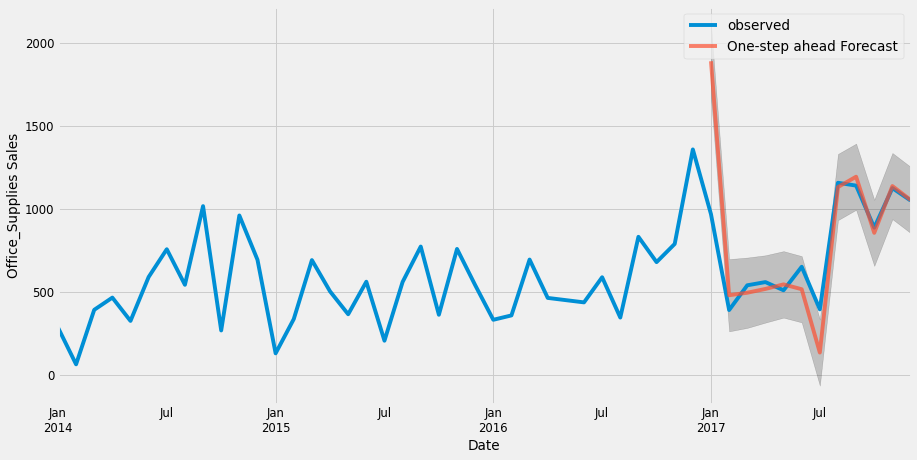

In [40]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Office_Supplies Sales')
plt.legend()
plt.show()

In [41]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Mean Squared Error of our forecasts is 79312.48
The Root Mean Squared Error of our forecasts is 281.62


Smaller the MSE closer we are to the line of best fit

### Diagnostic Checking

In [42]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy=forecast_accuracy(y_forecasted, y_truth)
display(forecast_accuracy)

{'mape': 0.19962620074089552,
 'me': 48.07569655112223,
 'mae': 137.81883631916847,
 'mpe': 0.019151199241665518,
 'rmse': 281.62471353775345,
 'corr': 0.8116685158940926,
 'minmax': 0.15679336630191232}

Since all of the values are low we can say our forecasting model is better.

### Producing And Visualizing Forecasts

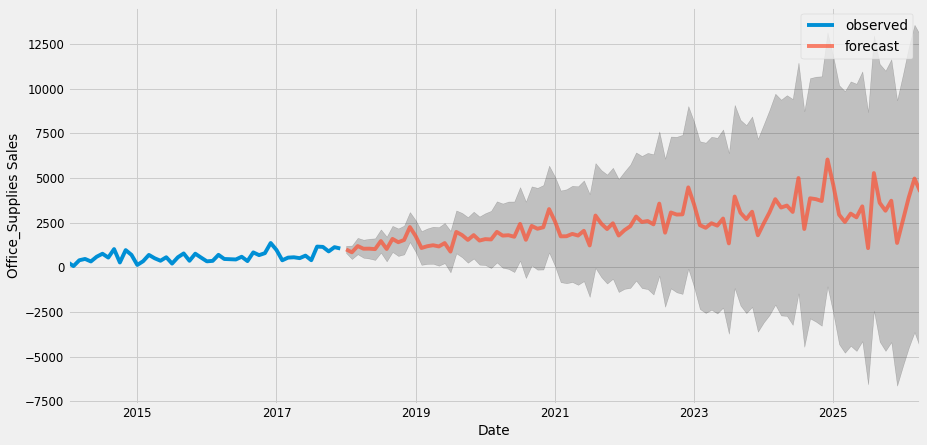

In [43]:
pred_ui = results.get_forecast(steps=100)
pred_ci = pred_ui.conf_int()
ax = y.plot(label='observed')
pred_ui.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Office_Supplies Sales')
plt.legend()
plt.show()